In [1]:
import math
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy import fftpack
from scipy.interpolate import CubicSpline
import time
from fastdtw import fastdtw
from collections import Counter
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv


colormap=np.array(['blue','#d10a3c','#6f7bbb','#3ac467','#c69942','#FF00FF','#DE9816','#87591A','#D473D4','#54F98D','#B3B191'])

# Function

In [73]:
def ComputeDtw_Matrix(mat,window=1): #Apply DTW to matrix. Return dissimilarity matrix
    res=np.zeros((mat.shape[0],mat.shape[0]))
    nb=res.shape[0]
    
    for i in range(nb):
        for j in range(i):
            res[i,j]=fastdtw(mat[i],mat[j],window)[0]
            
    return (res+res.T)

def ComputeCurveDerivate_Matrix(DF):#retourne la derivee des series temporelles 
    #r=lignes c=colonnes
    r,c=DF.shape
    #matrice nulle de taille r,
    M_derivate=np.zeros((r,len(np.arange(1,c+1))))
    
    for i in range(0,r):
        cs=CubicSpline(np.arange(1,c+1),DF.values[i])
        M_derivate[i]=cs(np.arange(1,c+1),1)#derivee premiere 

    return pd.DataFrame(M_derivate,columns=np.arange(1,c+1),index=DF.index)

def ComputeDerivativeSpectrum_Matrix(DF): #retourne la matrice des spectres
    r,c=DF.shape
    spectre=np.zeros((r,c))
    
    for i,sensor in enumerate(DF.values):
        #Fast Fourier Transfo        
        spectre[i]=abs(np.fft.fft(sensor))
        
    return spectre


def get_indice_individus(clust):#renvoie la position des individus de chaque cluster
    return [list(np.where(clust==elem)[0]) for elem in np.sort(list(Counter(clust)))]

#def get_individus(clust,data):#renvoie les individus composants chaque cluster
#    return [data.iloc[list(np.where(clust==elem)[0])].values for elem in np.sort(list(Counter(clust)))]

def get_individus(clust, data):
    dic={}
    for i,classe in enumerate(clust):
        if str(classe) not in dic.keys():
            dic[str(classe)]=[]
        dic[str(classe)].append(data.index[i])

    return (dic) 

def apply_clustering(data,k=2,critere="ward",window=1):
    
    #derivee    
    derivees=ComputeCurveDerivate_Matrix(data)

    #Fourier
    spectres=ComputeDerivativeSpectrum_Matrix(derivees)

    #DTW
    dist=ComputeDtw_Matrix(spectres,window)
    #print(dist)
    
    Z=linkage(dist,critere)
    clus=list(fcluster(Z,k,criterion="maxclust"))
    f=fcluster(Z,k,criterion="maxclust")
    
    return clus,Z,f

def get_dist(data, window=1):
    derivees=ComputeCurveDerivate_Matrix(data)
    spectres=ComputeDerivativeSpectrum_Matrix(derivees)
    dist=ComputeDtw_Matrix(spectres,window)
    return dist
    

# Apply Clustering on zone 1

In [61]:
env = CityLearnEnv(schema='citylearn_challenge_2020_climate_zone_1')

In [63]:
data = pd.DataFrame(columns=range(8760))

for i,e in enumerate(env.buildings):
    data.loc[data.shape[0]+1] = e.energy_simulation.non_shiftable_load
data = data.reset_index(drop=True)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,9.89,9.08,8.22,8.57,8.93,9.20,10.35,9.62,12.03,11.13,...,10.55,11.95,10.77,9.92,8.68,9.37,10.13,10.17,9.51,9.48
1,2.36,1.91,2.47,1.80,3.56,6.06,7.49,8.26,10.64,12.37,...,13.15,12.36,14.35,13.20,12.36,11.59,11.51,10.51,5.67,2.39
2,1.65,1.59,1.70,1.79,1.94,2.03,1.91,2.01,1.80,3.94,...,9.95,9.24,9.87,6.69,5.15,1.73,1.74,1.71,1.61,1.87
3,0.46,0.42,0.41,0.43,0.44,0.43,0.45,0.48,0.43,2.68,...,6.90,7.27,7.36,4.92,2.26,2.42,2.35,2.13,2.50,1.57
4,7.50,7.40,7.50,6.20,7.10,8.30,7.80,9.80,16.60,14.60,...,6.10,10.00,7.10,7.20,16.90,14.80,13.60,11.20,13.40,10.80


In [64]:
#days k=2
start=time.time()
cl2,z2,f2=apply_clustering(data,k=3,window=2)
print("temps d'exécution: ",time.time()-start,'s')
classes=get_individus(cl2,data)
print()

temps d'exécution:  40.32677435874939 s



C:\Users\Vincent\AppData\Local\Temp\ipykernel_328\1575556477.py:113: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z=linkage(dist,critere)


## Visualize clusters

Text(0, 0.5, 'Non shiftable load')

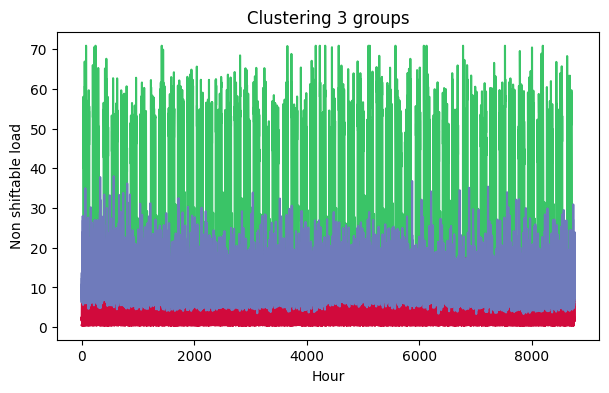

In [65]:
#plot
data.T.plot(legend=False,color=colormap[cl2] ,title='Clustering 3 groups',figsize=(7,4))
plt.xlabel("Hour")
plt.ylabel("Non shiftable load")

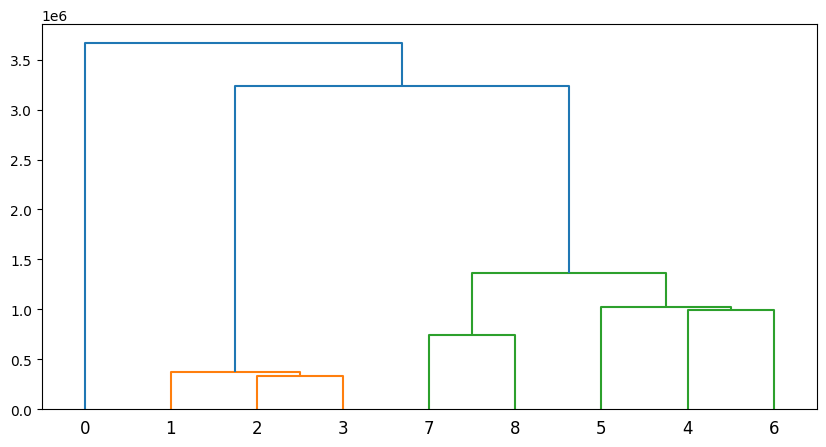

In [66]:
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(z2)

In [69]:
print(classes)

{'3': [0], '1': [1, 2, 3], '2': [4, 5, 6, 7, 8]}


# Classify new obs 

Get 1 control sample from each defined cluster

In [68]:
control_sample = data.loc[[0,1,4],:].reset_index(drop=True)
control_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,9.89,9.08,8.22,8.57,8.93,9.20,10.35,9.62,12.03,11.13,...,10.55,11.95,10.77,9.92,8.68,9.37,10.13,10.17,9.51,9.48
1,2.36,1.91,2.47,1.80,3.56,6.06,7.49,8.26,10.64,12.37,...,13.15,12.36,14.35,13.20,12.36,11.59,11.51,10.51,5.67,2.39
2,7.50,7.40,7.50,6.20,7.10,8.30,7.80,9.80,16.60,14.60,...,6.10,10.00,7.10,7.20,16.90,14.80,13.60,11.20,13.40,10.80


In [70]:
env2 = CityLearnEnv(schema='citylearn_challenge_2020_climate_zone_2')

data2 = pd.DataFrame(columns=range(8760))
for i,e in enumerate(env2.buildings):
    data2.loc[data2.shape[0]+1] = e.energy_simulation.non_shiftable_load
data2 = data2.reset_index(False)
data2.head()

,index,0,1,2,3,4,5,6,7,8,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,1,8.90,8.22,7.59,9.65,8.59,8.73,11.68,11.70,10.96,...,10.58,12.06,12.34,11.91,9.91,10.77,10.13,9.88,10.61,10.98
1,2,2.34,2.03,2.37,1.93,3.02,6.85,7.40,7.65,10.02,...,10.15,10.11,12.39,13.41,11.74,11.40,11.44,9.51,5.24,2.45
2,3,1.89,1.92,1.77,1.59,1.69,1.88,1.66,1.91,2.07,...,10.41,9.40,8.91,6.11,4.80,1.72,1.67,1.62,1.58,1.84
3,4,0.42,0.37,0.37,0.36,0.37,0.35,0.35,0.36,0.42,...,7.76,8.72,8.56,5.12,2.11,2.39,2.36,2.13,2.46,1.67
4,5,9.40,6.80,5.80,6.50,6.70,7.70,7.90,13.10,18.30,...,4.70,8.40,4.90,6.50,9.50,13.90,12.90,10.00,13.00,7.10


Add one new observation

In [110]:
data_classify = control_sample.copy()
data_classify.loc[data_classify.shape[0]+1] = data2.loc[0]
data_classify.head(6)

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,9.89,9.08,8.22,8.57,8.93,9.20,10.35,9.62,12.03,11.13,...,10.55,11.95,10.77,9.92,8.68,9.37,10.13,10.17,9.51,9.48
1,2.36,1.91,2.47,1.80,3.56,6.06,7.49,8.26,10.64,12.37,...,13.15,12.36,14.35,13.20,12.36,11.59,11.51,10.51,5.67,2.39
2,7.50,7.40,7.50,6.20,7.10,8.30,7.80,9.80,16.60,14.60,...,6.10,10.00,7.10,7.20,16.90,14.80,13.60,11.20,13.40,10.80
4,8.90,8.22,7.59,9.65,8.59,8.73,11.68,11.70,10.96,11.06,...,10.58,12.06,12.34,11.91,9.91,10.77,10.13,9.88,10.61,10.98


Compute distance matrix


(TODO: only distance between control and new sample, not distance between control samples)

In [111]:
dist_classify = get_dist(data_classify)

Get index of distance min for new obs:
* 0 : cluster 1
* 1 : cluster 2
* 2 : cluster 3

In [112]:
np.argmin(dist_classify[-1][:-1])

0